# 성능개선 기법 실습 개요

### (1) 각 모듈을 정의. 1)모델 학습,검증 2)dataset 생성 3)학습결과 시각화 함수
### (2) 모델링을 하기 위한 실습 세팅. 1)Import 2)하이퍼파라미터/변수 정의 3)데이터 로딩
### (3) 모델 성능개선에 영향을 미치는 아래의 요소에 대한 모델링을 진행하며, 하나하나 결과를 확인합니다.
#### - 큰모델 vs 작은모델
#### - Dropout
#### - Batch normalization
#### - Learning rate

# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [29]:
import os

os.makedirs("module", exist_ok=True)

In [ ]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi 
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) # 총 데이터포인트 개수 

    for X, y in dataloader:
        # 1. DEVICE로 이동.
        X, y = X.to(device), y.to(device)
        # 2. 모델 추정
        pred = model(X)
        # 3. loss 계산
        loss = loss_fn(pred, y)
        # 4. gradient 초기화
        optimizer.zero_grad()
        # 5. gradient 계산
        loss.backward()
        # 6. 파라미터 업데이트
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)

        ############ 1 epoch 학습 종료 -> LR를 변경 ########### 
        if lr_scheduler is not None: 
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")
    

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [31]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


## utils.py


In [32]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


## Import

In [33]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [35]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [36]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

In [14]:
classes
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [41]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(28*28, 10) # 입력 -> 출력

    def forward(self, X):
        X = nn.Flatten()(X)
        out = self.lr(X)
        return out

In [42]:
small_model = SmallModel().to(device)
summary(small_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

In [43]:
loss_fn = nn.CrossEntropyLoss() # 다중분류의 loss함수
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [46]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader,
    test_loader,
    small_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=10,
    device=device,
    mode='multi'
)
# 에폭설정(patience=5,)을 안해서, 오래걸려서 중간에 끊음


Epoch[1/100] - Train loss: 0.48782 Train Accucracy: 0.87837 || Validation Loss: 0.46481 Validation Accuracy: 0.88760
Epoch[2/100] - Train loss: 0.38100 Train Accucracy: 0.89960 || Validation Loss: 0.36316 Validation Accuracy: 0.90350
Epoch[3/100] - Train loss: 0.34024 Train Accucracy: 0.90832 || Validation Loss: 0.32500 Validation Accuracy: 0.91100
Epoch[4/100] - Train loss: 0.31761 Train Accucracy: 0.91372 || Validation Loss: 0.30586 Validation Accuracy: 0.91440
Epoch[5/100] - Train loss: 0.30299 Train Accucracy: 0.91697 || Validation Loss: 0.29187 Validation Accuracy: 0.91780
Epoch[6/100] - Train loss: 0.29300 Train Accucracy: 0.91917 || Validation Loss: 0.28558 Validation Accuracy: 0.92150
Epoch[7/100] - Train loss: 0.28522 Train Accucracy: 0.92103 || Validation Loss: 0.27972 Validation Accuracy: 0.92060
Epoch[8/100] - Train loss: 0.27946 Train Accucracy: 0.92248 || Validation Loss: 0.27469 Validation Accuracy: 0.92290
Epoch[9/100] - Train loss: 0.27463 Train Accucracy: 0.92440 || V

KeyboardInterrupt: 

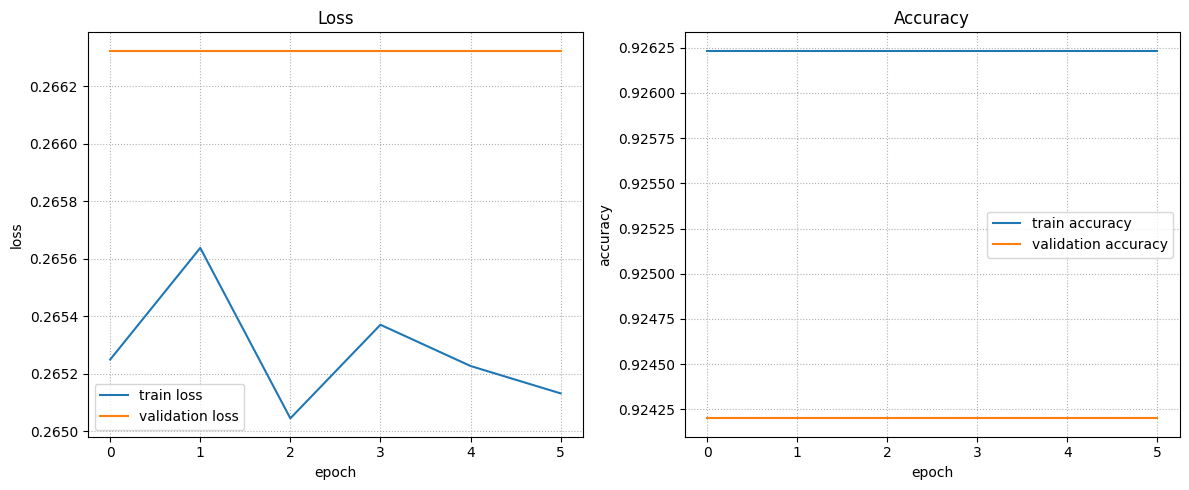

In [47]:
# 작은모델 plot
plot_fit_result(
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list
)

## 큰모델

In [31]:
###### nn.Sequential() -> layer block: 레이어함수들을 묶어 놓은 블록
s = nn.Sequential(
    nn.Linear(10,20),
    nn.ReLU(),
    nn.Linear(20,30),
    nn.ReLU()
)
i = torch.randn(5, 10, dtype=torch.float32)
o = s(i)
print(o.shape)
o #>>> 0.000으로 나오는 것들은 음수였는데 ReLU에 의해 0으로 된것

torch.Size([5, 30])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2714e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.6748e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0386e-01, 7.7826e-02, 0.0000e+00, 2.0380e-01, 3.1221e-01, 1.8077e-02,
         2.4093e-02, 1.8663e-04, 3.2974e-01, 1.4195e-02, 0.0000e+00, 2.4897e-01,
         0.0000e+00, 1.0341e-01, 1.8181e-01, 0.0000e+00, 0.0000e+00, 1.8827e-01],
        [0.0000e+00, 0.0000e+00, 1.1900e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.5468e-01, 6.6918e-02, 0.0000e+00, 7.4739e-02, 0.0000e+00,
         0.0000e+00, 2.4118e-02, 0.0000e+00, 0.0000e+00, 1.2763e-02, 4.1417e-02,
         1.6288e-01, 0.0000e+00, 0.0000e+00, 2.9203e-01, 0.0000e+00, 3.6338e-01,
         7.4426e-02, 2.6210e-01, 1.4978e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.3084e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 7.1425e-02, 2.9188e-01, 0.0000e+00, 0.0000e+00, 5.1404e-02,
         6.3403e-02, 0.000

In [34]:
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [35]:
big_model = BigModel().to(device)
summary(big_model, (100,1,28,28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-4                       [100, 1024]               2,098,176
│    └─ReLU: 2-5                         [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-6                       [100, 512]                524,800
│    └─ReLU: 2-7                         [100, 512]                --
├─Sequential: 1-4                        [100, 256]                --
│    └─Linear: 2-8                       [100, 256]               

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

In [38]:
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = fit(
    train_loader, test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.14920 Train Accucracy: 0.95723 || Validation Loss: 0.16091 Validation Accuracy: 0.95320
Epoch[2/100] - Train loss: 0.08835 Train Accucracy: 0.97482 || Validation Loss: 0.11908 Validation Accuracy: 0.96470
Epoch[3/100] - Train loss: 0.07025 Train Accucracy: 0.97918 || Validation Loss: 0.10939 Validation Accuracy: 0.96950
Epoch[4/100] - Train loss: 0.03253 Train Accucracy: 0.99150 || Validation Loss: 0.08205 Validation Accuracy: 0.97860
Epoch[5/100] - Train loss: 0.03859 Train Accucracy: 0.98928 || Validation Loss: 0.08699 Validation Accuracy: 0.97690
Epoch[6/100] - Train loss: 0.03701 Train Accucracy: 0.98943 || Validation Loss: 0.09888 Validation Accuracy: 0.97630
Epoch[7/100] - Train loss: 0.03225 Train Accucracy: 0.99002 || Validation Loss: 0.10283 Validation Accuracy: 0.97510
Epoch[8/100] - Train loss: 0.02389 Train Accucracy: 0.99293 || Validation Loss: 0.09545 Validation Accuracy: 0.97730
Epoch[9/100] - Train loss: 0.03024 Train Accucracy: 0.99128 || V

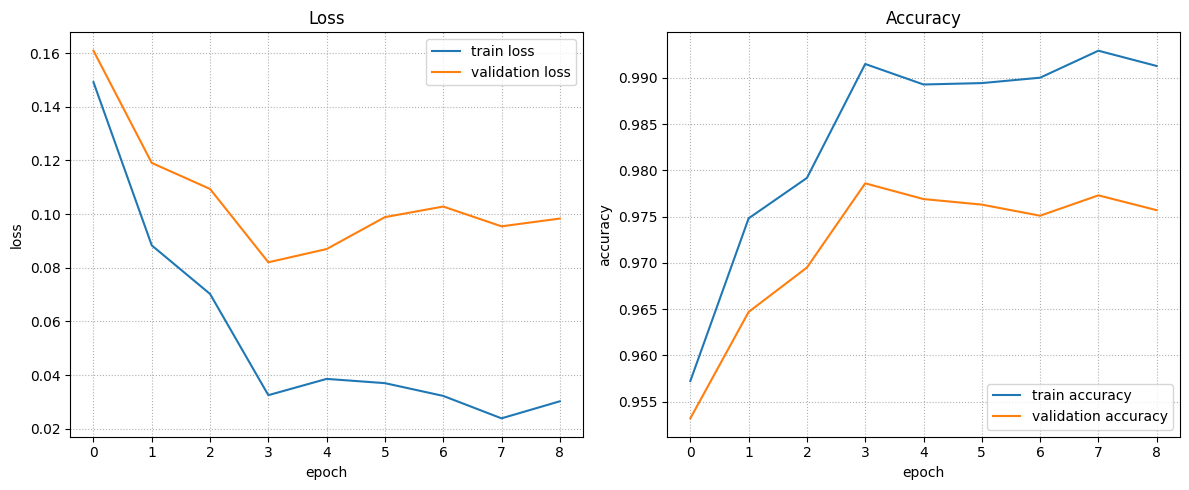

In [40]:
# 큰모델 plot
plot_fit_result(
    train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2
)

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [48]:
class DropoutModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)
    

In [49]:
dout_model = DropoutModel(drop_rate=0.5).to(device)
summary(dout_model, (100,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─ReLU: 2-6                         [100, 1024]               --
│    └─Dropout: 2-7                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-8                       [100, 512]                524,800
│    └─ReLU: 2-9                         [100, 512]               

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

In [52]:
train_loss_list3, train_acc_list3, valid_loss_list3, valid_acc_list3 = fit(
    train_loader, test_loader,
    dout_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.99098 Train Accucracy: 0.70987 || Validation Loss: 0.99735 Validation Accuracy: 0.72080
Epoch[2/100] - Train loss: 0.44286 Train Accucracy: 0.82250 || Validation Loss: 0.44771 Validation Accuracy: 0.82630
Epoch[3/100] - Train loss: 0.34625 Train Accucracy: 0.89855 || Validation Loss: 0.36845 Validation Accuracy: 0.89820
Epoch[4/100] - Train loss: 0.30674 Train Accucracy: 0.94168 || Validation Loss: 0.33937 Validation Accuracy: 0.93970
Epoch[5/100] - Train loss: 0.26920 Train Accucracy: 0.95068 || Validation Loss: 0.29659 Validation Accuracy: 0.94800
Epoch[6/100] - Train loss: 0.23369 Train Accucracy: 0.96032 || Validation Loss: 0.30530 Validation Accuracy: 0.95400
Epoch[7/100] - Train loss: 0.20569 Train Accucracy: 0.96357 || Validation Loss: 0.27473 Validation Accuracy: 0.95790
Epoch[8/100] - Train loss: 0.18081 Train Accucracy: 0.96685 || Validation Loss: 0.23953 Validation Accuracy: 0.95980
Epoch[9/100] - Train loss: 0.17122 Train Accucracy: 0.96665 || V

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [3]:
# nn.BatchNorm1d(입력 feature개수)
# Lenear -> BatchNorm -> ReLU(Activation)
# Lenear -> BatchNorm -> ReLU(Activation) -> Dropout

class BatchNormModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [ ]:
bn_model = BatchNormModel(drop_rate=0.5).to(device)
summary(bn_model, (100,1,28,28))

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [69]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

#### StepLR


In [70]:
# step을 진행하다가 내가 지정한 step에 도달하면 특정 비율로 LR을 줄이고 진행하고, 그 다음 지정 step이 되면 LR을 줄이고 진행하는 방식으로 진행.(계단식)
small_model = SmallModel()
optim = torch.optim.Adam(small_model.parameters(),lr=0.001)

# optimizer에서 현재 LR을 조회
optim.param_groups[0]["lr"]

0.001

In [71]:
#LearningRate Scheduler - StepLR - 계단 형태로 LR을 특정 step마다 특정 비율로 줄여나간다.
# 아래는 30step마다 LR을 '현재학습률'을 0.5배하며 변경
steplr_scheduler = torch.optim.lr_scheduler.StepLR(
    optim, # 학습률을 변경할 optimizer
    step_size = 30, # 몇 step마다 Learning을 변경할지. >>> 구현하기 따라 epoch으로 넣을 수 있다. >> 지금은 lr_scheduler.step(): 이것이 30번 실행되면 LR*gamma로 변경
    gamma =0.5 # 변경할 비율.
)

# 현재 LR을 스케쥴러로부터 조회
steplr_scheduler.get_last_lr()

[0.001]

In [72]:
# 통상의 순서
## 모델 생성
## Loss 함수 생성
## optimizer 생성
## LR scheduer 생성

# 학습
epochs = 300
step_size = 10 # len(dataloader)와 같은 값
lr_list =[]

for epoch in range(epochs):

    for step in range(step_size): # for x,y in dataloader 의 역할과 같다.
        # 1 steop 학습
        # x,y device로 이동
        # 추론 >> p = model(x)
        # loss. loss = loss_fn(p,y)
        # grad. loss.backward()
        optim.step() # update 작업
        optim.zero_grad() # grad 초기화

        steplr_scheduler.step() # LR를 변경 요청.
        lr_list.append(steplr_scheduler.get_last_lr()) # step()후 lr을 list에 저장

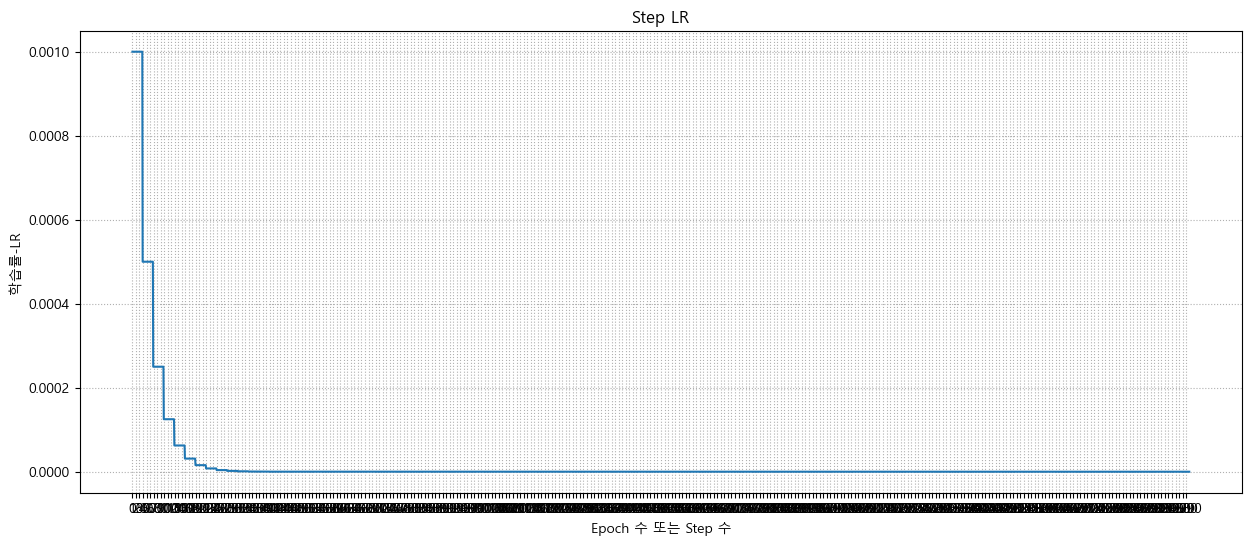

In [73]:
plt.rcParams['font.family'] = 'malgun gothic'
plot_lr("Step LR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [74]:
optim = torch.optim.Adam(small_model.parameters(), lr = 0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    T_max=10, # 변화주기 step/epoch - 최댓값(초기 LR)에서 최솟값까지 가는데 10epoch, 최솟값에서 최댓값으로 가는데 10epoch
    eta_min=1e-6, #lr 최소값 지정
)

In [77]:
lr_list = []
for epoch in range(epochs):
    for step in range(step_size):
        # ... 학습
        optim.step()
        optim.zero_grad()

    ca_lr_scheduler.step() # epoch단위로 lr변경
    lr_list.append(ca_lr_scheduler.get_last_lr())
    

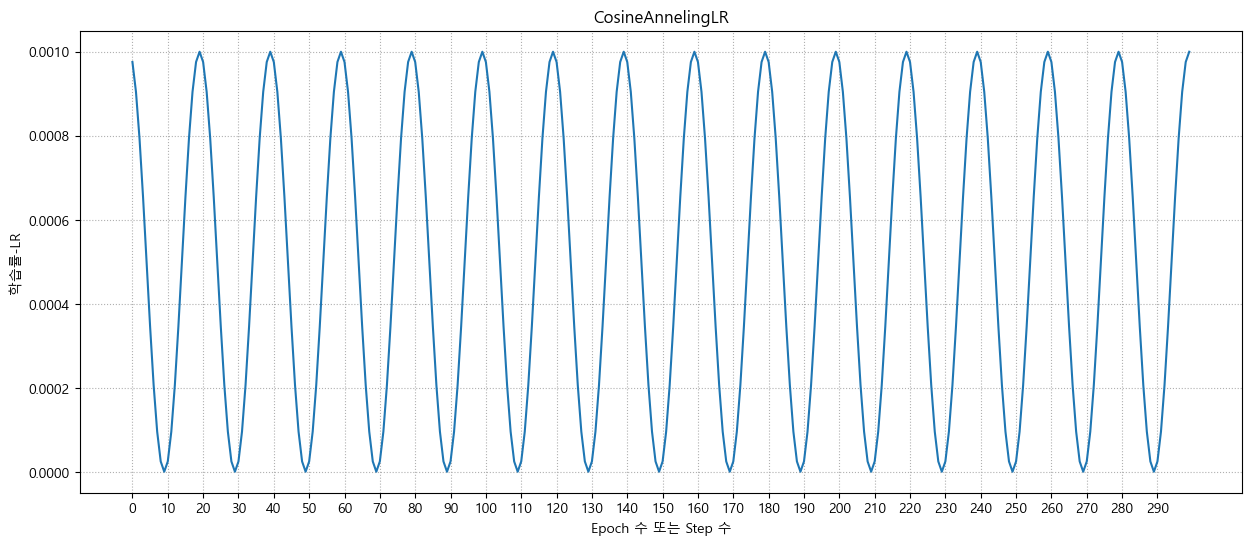

In [78]:
plot_lr("CosineAnnelingLR", lr_list)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)
일정한 주기가 아닌, 변화의 주기를 늘린다.


In [82]:
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=10, # 변화주기(step/epoch)
    T_mult=2, # 새로운 변화주기(T_0) = 현재 T_0 * T_mult (한 주기가 끝날때마다 T_0를 다시 계산) 
    eta_min=1e-6 # 0.000001
)

In [85]:
lr_list = []
for epoch in range(epochs):
    
    for step in range(step_size):
        # 학습
        optim.step()
        optim.zero_grad()

    cawr_lr_scheduler.step()
    lr_list.append(cawr_lr_scheduler.get_last_lr())

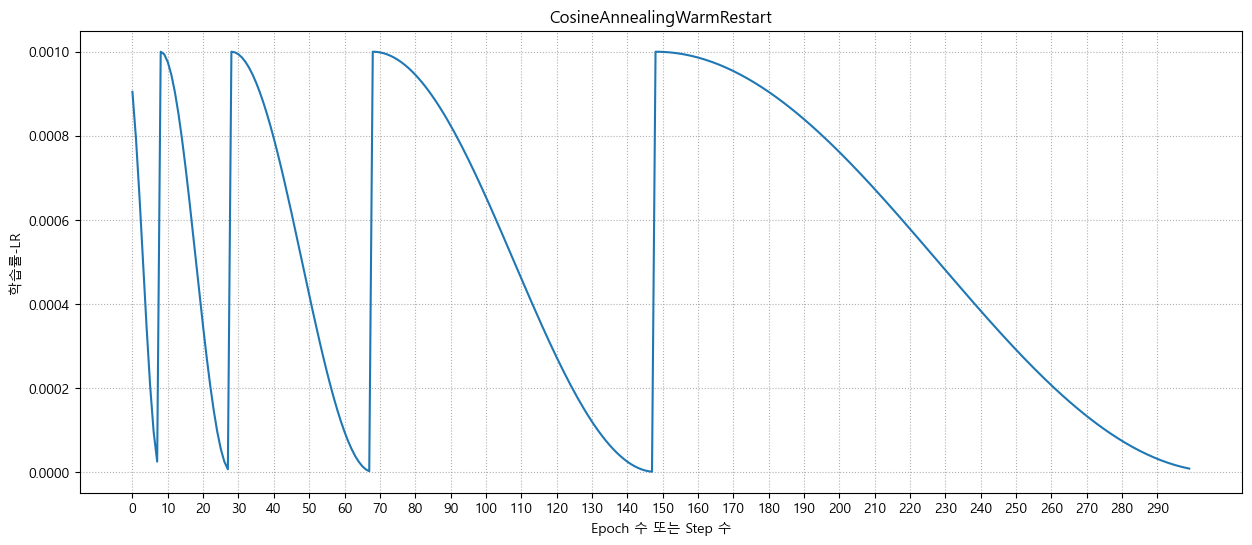

In [86]:
plot_lr("CosineAnnealingWarmRestart", lr_list)